/tmp/ipykernel_1857318/93253677.py:47: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import zoom
2024-07-15 13:03:22.938195: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-07-15 13:03:22.938283: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nid004079): /proc/driver/nvidia/version does not exist
2024-07-15 13:03:22.940203: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 1)]                                                           
                                                                                                  
 conv3d_3 (Conv3D)              (None, 128, 128, 12  448         ['input_4[0][0]']                
                                8, 16)                                                            
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 12  64         ['conv3d_3[0][0]']               
 alization)                     8, 16)                                                      

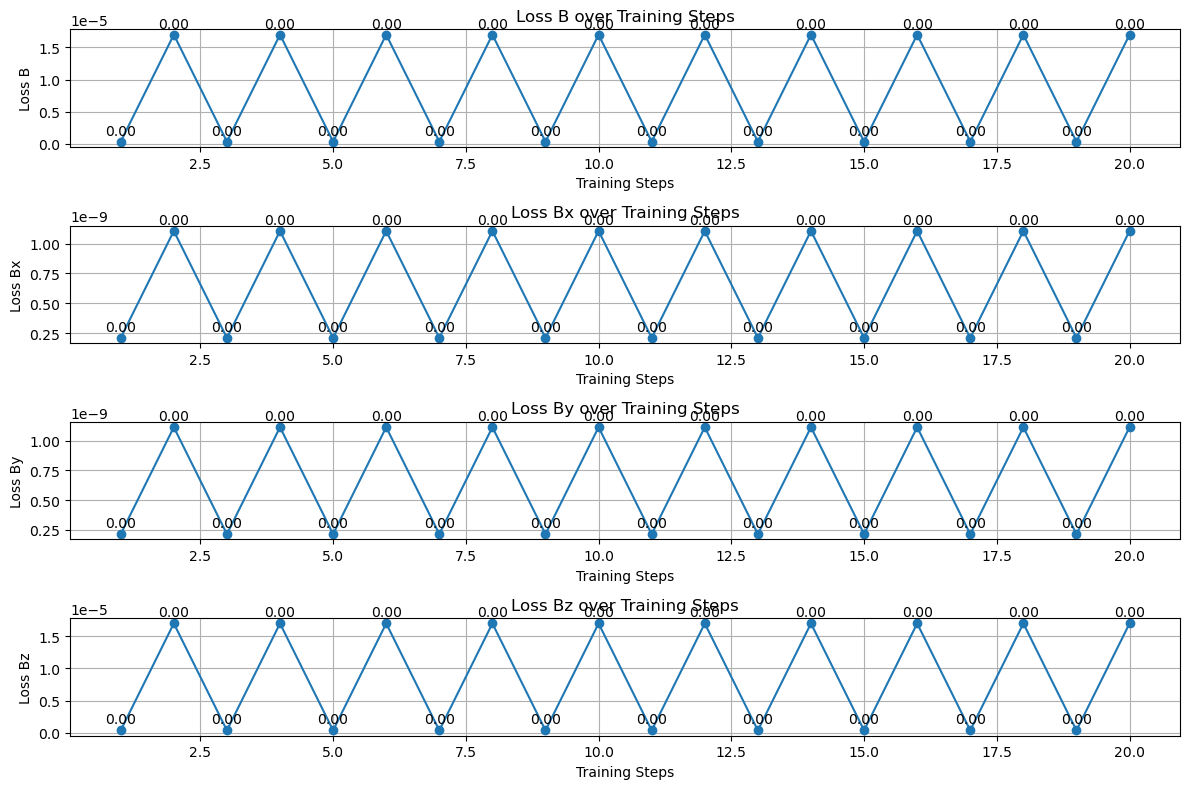

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
@author: Alexander Scheinker
"""

import numpy as np
import h5py

import tensorflow as tf
from tensorflow.keras import mixed_precision

# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_global_policy(policy)

# print('Compute dtype: %s' % policy.compute_dtype)
# print('Variable dtype: %s' % policy.variable_dtype)


from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Conv3D, Conv3DTranspose, UpSampling2D
from tensorflow.keras.layers import concatenate, Add, MaxPool3D, UpSampling3D, Reshape, Multiply, MaxPool2D
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, Flatten, BatchNormalization
from tensorflow.keras.models import Model

from tensorflow import keras

from tensorflow.keras.regularizers import l2 as l2_reg
from tensorflow.keras.regularizers import l1 as l1_reg
from tensorflow.keras.regularizers import l1_l2 as l1_l2_reg

import matplotlib.pyplot as plt
import matplotlib
import time
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import random
from scipy.io import loadmat
from scipy import misc
import os
import csv
# from sklearn.preprocessing import QuantileTransformer, StandardScaler

from scipy.ndimage import gaussian_filter
from scipy.ndimage.interpolation import zoom
from scipy import ndimage

import gc
import pickle

DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)


PATH_TO_VOLUME_DATA  = '/pscratch/sd/j/jcurcio/pcnn/Volume_Data/'

#%%

# The 3D volumes have dimensions n_pixels*n_pixels*n_pixels
n_pixels = 128

n_timesteps = 200

# Import data

# Charge density
Q = np.zeros([n_timesteps,n_pixels,n_pixels,n_pixels,1])

# Non-zero charge density locations
Qnz = np.zeros([n_timesteps,n_pixels,n_pixels,n_pixels,1])

# Electric field components
Ex = np.zeros([n_timesteps,n_pixels,n_pixels,n_pixels,1])
Ey = np.zeros([n_timesteps,n_pixels,n_pixels,n_pixels,1])
Ez = np.zeros([n_timesteps,n_pixels,n_pixels,n_pixels,1])

# Magnetic field components
Bx = np.zeros([n_timesteps,n_pixels,n_pixels,n_pixels,1])
By = np.zeros([n_timesteps,n_pixels,n_pixels,n_pixels,1])
Bz = np.zeros([n_timesteps,n_pixels,n_pixels,n_pixels,1])

# Current density components
Jx = np.zeros([n_timesteps,n_pixels,n_pixels,n_pixels,1])
Jy = np.zeros([n_timesteps,n_pixels,n_pixels,n_pixels,1])
Jz = np.zeros([n_timesteps,n_pixels,n_pixels,n_pixels,1])

# Load the data
for n_load in np.arange(n_timesteps):

    Q[n_load] = np.load(PATH_TO_VOLUME_DATA + f'q_3D_vol_{n_pixels}_{n_load}.npy').reshape([1,n_pixels,n_pixels,n_pixels,1])

    #Qnz[n_load] = np.load(PATH_TO_VOLUME_DATA + f'Qnz_3D_vol_{n_pixels}_{n_load}.npy').reshape([1,n_pixels,n_pixels,n_pixels,1])

    Ex[n_load] = np.load(PATH_TO_VOLUME_DATA + f'Ex_3D_vol_{n_pixels}_{n_load}.npy').reshape([1,n_pixels,n_pixels,n_pixels,1])
    Ey[n_load] = np.load(PATH_TO_VOLUME_DATA + f'Ey_3D_vol_{n_pixels}_{n_load}.npy').reshape([1,n_pixels,n_pixels,n_pixels,1])
    Ez[n_load] = np.load(PATH_TO_VOLUME_DATA + f'Ez_3D_vol_{n_pixels}_{n_load}.npy').reshape([1,n_pixels,n_pixels,n_pixels,1])

    Bx[n_load] = np.load(PATH_TO_VOLUME_DATA + f'Bx_3D_vol_{n_pixels}_{n_load}.npy').reshape([1,n_pixels,n_pixels,n_pixels,1])
    By[n_load] = np.load(PATH_TO_VOLUME_DATA + f'By_3D_vol_{n_pixels}_{n_load}.npy').reshape([1,n_pixels,n_pixels,n_pixels,1])
    Bz[n_load] = np.load(PATH_TO_VOLUME_DATA + f'Bz_3D_vol_{n_pixels}_{n_load}.npy').reshape([1,n_pixels,n_pixels,n_pixels,1])

    Jx[n_load] = np.load(PATH_TO_VOLUME_DATA + f'Jx_3D_vol_{n_pixels}_{n_load}.npy').reshape([1,n_pixels,n_pixels,n_pixels,1])
    Jy[n_load] = np.load(PATH_TO_VOLUME_DATA + f'Jy_3D_vol_{n_pixels}_{n_load}.npy').reshape([1,n_pixels,n_pixels,n_pixels,1])
    Jz[n_load] = np.load(PATH_TO_VOLUME_DATA + f'Jz_3D_vol_{n_pixels}_{n_load}.npy').reshape([1,n_pixels,n_pixels,n_pixels,1])


# Latent space inputs, un-used, all zeros
z_input = np.zeros([n_timesteps,8,8,8,1]).astype(np.float32)

# Used to un-normalize PINN and no-physics CNN outputs
Bxyz_all_max = np.load(PATH_TO_VOLUME_DATA + 'Bxyz_max.npy')

# Normalize CNN inputs
J_max_max_all_128 = np.load(PATH_TO_VOLUME_DATA+'J_max_max_all_128.npy')

Jx = Jx/J_max_max_all_128
Jy = Jy/J_max_max_all_128
Jz = Jz/J_max_max_all_128

Bx = Bx/Bxyz_all_max
By = By/Bxyz_all_max
Bz = Bz/Bxyz_all_max

# Make 3D field data for the PINN and No-Physics CNNs for current density
Jxyz = np.zeros([n_timesteps,n_pixels,n_pixels,n_pixels,3])
Jxyz[:,:,:,:,0] = Jx[:,:,:,:,0]
Jxyz[:,:,:,:,1] = Jy[:,:,:,:,0]
Jxyz[:,:,:,:,2] = Jz[:,:,:,:,0]

Bxyz = np.zeros([n_timesteps,n_pixels,n_pixels,n_pixels,3])
Bxyz[:,:,:,:,0] = Bx[:,:,:,:,0]
Bxyz[:,:,:,:,1] = By[:,:,:,:,0]
Bxyz[:,:,:,:,2] = Bz[:,:,:,:,0]

# Non-zero charge density locations
Qnz_3D = np.zeros([n_timesteps,n_pixels,n_pixels,n_pixels,3]).astype(np.float32)
Qnz_3D[:,:,:,:,0] = Qnz[:,:,:,:,0]
Qnz_3D[:,:,:,:,1] = Qnz[:,:,:,:,0]
Qnz_3D[:,:,:,:,2] = Qnz[:,:,:,:,0]


# In[11]:

# Define the physical space

# Some physics constants
u0 = tf.constant(4.0*np.pi*1e-7, dtype=DTYPE)
e0 = tf.constant(8.85*1e-12, dtype=DTYPE)
cc = tf.constant(2.99792e8, dtype=DTYPE)

# Physical size of the volume around the beam
x_max_all = 6.992009440856081e-05
x_min_all = -6.997896993744958e-05

y_max_all = 6.99964109005157e-05
y_min_all = -6.949648426854683e-05

z_max_all = 1.1389556140820954e-06
z_min_all = 4.0295594061272973e-10

# More physics constants
me = 9.109384e-31
ce = 2.99792458e8
qe = 1.602e-19

# Size of one pixel
dx = (x_max_all-x_min_all)/(n_pixels-1)
dy = (y_max_all-y_min_all)/(n_pixels-1)
dz = (z_max_all-z_min_all)/(n_pixels-1)

# Axis for plotting
x_axis = np.linspace(x_min_all,x_max_all,n_pixels)
y_axis = np.linspace(y_min_all,y_max_all,n_pixels)
z_axis = np.linspace(z_min_all,z_max_all,n_pixels)

# Time step between saved beam volumes
dt = 5e-11

# Defined filters for derivatives as a convolutional layer
d_dx = np.zeros([3,3,3])
d_dx[0,1,1] = -1
d_dx[2,1,1] = 1
d_dx = tf.keras.initializers.Constant(d_dx/2)

d_dy = np.zeros([3,3,3])
d_dy[1,0,1] = -1
d_dy[1,2,1] = 1
d_dy = tf.keras.initializers.Constant(d_dy/2)

d_dz = np.zeros([3,3,3])
d_dz[1,1,0] = -1
d_dz[1,1,2] = 1
d_dz = tf.keras.initializers.Constant(d_dz/2)

# Single layerr 3D CNNs for taking partial x, y, and z derivatives
def NN_ddx():
    X = Input(shape = (n_pixels,n_pixels,n_pixels,1))
    X_x = Conv3D(1, kernel_size=3, kernel_initializer=d_dx, strides=[1,1,1], padding='SAME', trainable=False)(X)
    d_dx_model = Model(inputs=[X], outputs=[X_x])
    return d_dx_model

def NN_ddy():
    X = Input(shape = (n_pixels,n_pixels,n_pixels,1))
    X_y = Conv3D(1, kernel_size=3, kernel_initializer=d_dy, strides=[1,1,1], padding='SAME', trainable=False)(X)
    d_dy_model = Model(inputs=[X], outputs=[X_y])
    return d_dy_model

def NN_ddz():
    X = Input(shape = (n_pixels,n_pixels,n_pixels,1))
    X_z = Conv3D(1, kernel_size=3, kernel_initializer=d_dz, strides=[1,1,1], padding='SAME', trainable=False)(X)
    d_dz_model = Model(inputs=[X], outputs=[X_z])
    return d_dz_model

# Partial Derivative CNNs
mNN_ddx = NN_ddx()
mNN_ddy = NN_ddy()
mNN_ddz = NN_ddz()

# Latent space inputs, un-used, all zeros
z_input = np.zeros([n_timesteps,8,8,8,1]).astype(np.float32)

#%%

def Field_model():

    # Regularlization
    l2w = 1e-6

    # Various resolution image inputs
    X_in = Input(shape = (128,128,128,1))
    ES_in = Input(shape = (8,8,8,1))

    qPxPyPz_128 = Conv3D(16, kernel_size=3, strides=(1,1,1), padding='same', kernel_regularizer=l2_reg(l2w))(X_in)
    qPxPyPz_128 = BatchNormalization()(qPxPyPz_128)
    qPxPyPz_128 = layers.LeakyReLU(alpha=0.1)(qPxPyPz_128)
    qPxPyPz_128 = Conv3D(16, kernel_size=3, strides=(1,1,1), padding='same', kernel_regularizer=l2_reg(l2w))(qPxPyPz_128)
    qPxPyPz_128 = BatchNormalization()(qPxPyPz_128)
    qPxPyPz_128 = layers.LeakyReLU(alpha=0.1)(qPxPyPz_128)
    # 128x128x128

    qPxPyPz_64 = MaxPool3D(pool_size=(2,2,2))(qPxPyPz_128)
    # 64x64x64

    qPxPyPz_64 = Conv3D(32, kernel_size=3, strides=(1,1,1), padding='same', kernel_regularizer=l2_reg(l2w))(qPxPyPz_64)
    qPxPyPz_64 = BatchNormalization()(qPxPyPz_64)
    qPxPyPz_64 = layers.LeakyReLU(alpha=0.1)(qPxPyPz_64)
    qPxPyPz_64 = Conv3D(32, kernel_size=3, strides=(1,1,1), padding='same', kernel_regularizer=l2_reg(l2w))(qPxPyPz_64)
    qPxPyPz_64 = BatchNormalization()(qPxPyPz_64)
    qPxPyPz_64 = layers.LeakyReLU(alpha=0.1)(qPxPyPz_64)
    # 64x64x64

    qPxPyPz_32 = MaxPool3D(pool_size=(2,2,2))(qPxPyPz_64)
    # 32x32x32

    qPxPyPz_32 = Conv3D(64, kernel_size=3, strides=(1,1,1), padding='same', kernel_regularizer=l2_reg(l2w))(qPxPyPz_32)
    qPxPyPz_32 = BatchNormalization()(qPxPyPz_32)
    qPxPyPz_32 = layers.LeakyReLU(alpha=0.1)(qPxPyPz_32)
    qPxPyPz_32 = Conv3D(64, kernel_size=3, strides=(1,1,1), padding='same', kernel_regularizer=l2_reg(l2w))(qPxPyPz_32)
    qPxPyPz_32 = BatchNormalization()(qPxPyPz_32)
    qPxPyPz_32 = layers.LeakyReLU(alpha=0.1)(qPxPyPz_32)
    # 32x32x32

    qPxPyPz_16 = MaxPool3D(pool_size=(2,2,2))(qPxPyPz_32)
    # 16x16x16

    qPxPyPz_16 = Conv3D(128, kernel_size=3, strides=(1,1,1), padding='same', kernel_regularizer=l2_reg(l2w))(qPxPyPz_16)
    qPxPyPz_16 = BatchNormalization()(qPxPyPz_16)
    qPxPyPz_16 = layers.LeakyReLU(alpha=0.1)(qPxPyPz_16)
    qPxPyPz_16 = Conv3D(128, kernel_size=3, strides=(1,1,1), padding='same', kernel_regularizer=l2_reg(l2w))(qPxPyPz_16)
    qPxPyPz_16 = BatchNormalization()(qPxPyPz_16)
    qPxPyPz_16 = layers.LeakyReLU(alpha=0.1)(qPxPyPz_16)
    # 16x16x16

    qPxPyPz_8 = MaxPool3D(pool_size=(2,2,2))(qPxPyPz_16)
    # 8x8x8

    qPxPyPz_8 = Conv3D(64, kernel_size=3, strides=(1,1,1), padding='same', kernel_regularizer=l2_reg(l2w))(qPxPyPz_8)
    qPxPyPz_8 = BatchNormalization()(qPxPyPz_8)
    qPxPyPz_8 = layers.LeakyReLU(alpha=0.1)(qPxPyPz_8)
    qPxPyPz_8 = Conv3D(64, kernel_size=3, strides=(1,1,1), padding='same', kernel_regularizer=l2_reg(l2w))(qPxPyPz_8)
    qPxPyPz_8 = BatchNormalization()(qPxPyPz_8)
    qPxPyPz_8 = layers.LeakyReLU(alpha=0.1)(qPxPyPz_8)
    # 8x8x8
    qPxPyPz_8 = Conv3D(1, kernel_size=3, strides=(1,1,1), padding='same', kernel_regularizer=l2_reg(l2w))(qPxPyPz_8)
    qPxPyPz_8 = BatchNormalization()(qPxPyPz_8)
    qPxPyPz_8 = layers.LeakyReLU(alpha=0.1)(qPxPyPz_8)
    # 8x8x8x1

    adapt_in = Add()([qPxPyPz_8,ES_in])
    # 8x8x8x1

    A_8 = Conv3D(64, kernel_size=3, strides=(1,1,1), padding='same', kernel_regularizer=l2_reg(l2w))(adapt_in)
    A_8 = BatchNormalization()(A_8)
    A_8 = layers.LeakyReLU(alpha=0.1)(A_8)
    A_8 = Conv3D(64, kernel_size=3, strides=(1,1,1), padding='same', kernel_regularizer=l2_reg(l2w))(A_8)
    A_8 = BatchNormalization()(A_8)
    A_8 = layers.LeakyReLU(alpha=0.1)(A_8)
    # 8x8x8

    A_16 = Conv3DTranspose(64, kernel_size=3, strides=(2,2,2), padding='same', kernel_regularizer=l2_reg(l2w))(A_8)
    A_16 = BatchNormalization()(A_16)
    A_16 = layers.LeakyReLU(alpha=0.1)(A_16)
    # 16x16x16
    A_16 = Conv3D(64, kernel_size=3, strides=(1,1,1), padding='same', kernel_regularizer=l2_reg(l2w))(A_16)
    A_16 = BatchNormalization()(A_16)
    A_16 = layers.LeakyReLU(alpha=0.1)(A_16)
    A_16 = Conv3D(64, kernel_size=3, strides=(1,1,1), padding='same', kernel_regularizer=l2_reg(l2w))(A_16)
    A_16 = BatchNormalization()(A_16)
    A_16 = layers.LeakyReLU(alpha=0.1)(A_16)
    # 16x16x16

    A_32 = Conv3DTranspose(64, kernel_size=3, strides=(2,2,2), padding='same', kernel_regularizer=l2_reg(l2w))(A_16)
    A_32 = BatchNormalization()(A_32)
    A_32 = layers.LeakyReLU(alpha=0.1)(A_32)
    # 32x32x32
    A_32 = Conv3D(64, kernel_size=3, strides=(1,1,1), padding='same', kernel_regularizer=l2_reg(l2w))(A_32)
    A_32 = BatchNormalization()(A_32)
    A_32 = layers.LeakyReLU(alpha=0.1)(A_32)
    A_32 = Conv3D(64, kernel_size=3, strides=(1,1,1), padding='same', kernel_regularizer=l2_reg(l2w))(A_32)
    A_32 = BatchNormalization()(A_32)
    A_32 = layers.LeakyReLU(alpha=0.1)(A_32)
    # 32x32x32

    A_64 = Conv3DTranspose(32, kernel_size=3, strides=(2,2,2), padding='same', kernel_regularizer=l2_reg(l2w))(A_32)
    A_64 = BatchNormalization()(A_64)
    A_64 = layers.LeakyReLU(alpha=0.1)(A_64)
    # 64x64x64
    A_64 = Conv3D(32, kernel_size=3, strides=(1,1,1), padding='same', kernel_regularizer=l2_reg(l2w))(A_64)
    A_64 = BatchNormalization()(A_64)
    A_64 = layers.LeakyReLU(alpha=0.1)(A_64)
    A_64 = Conv3D(32, kernel_size=3, strides=(1,1,1), padding='same', kernel_regularizer=l2_reg(l2w))(A_64)
    A_64 = BatchNormalization()(A_64)
    A_64 = layers.LeakyReLU(alpha=0.1)(A_64)
    # Ax_64 = Conv3D(1, kernel_size=3, strides=(1,1,1), padding='same', activation='linear')(Ax_64)
    # 64x64x64

    A_128 = Conv3DTranspose(16, kernel_size=3, strides=(2,2,2), padding='same', kernel_regularizer=l2_reg(l2w))(A_64)
    A_128 = BatchNormalization()(A_128)
    A_128 = layers.LeakyReLU(alpha=0.1)(A_128)
    # 128x128x128
    A_128 = Conv3D(16, kernel_size=3, strides=(1,1,1), padding='same', kernel_regularizer=l2_reg(l2w))(A_128)
    A_128 = BatchNormalization()(A_128)
    A_128 = layers.LeakyReLU(alpha=0.1)(A_128)
    A_128 = Conv3D(16, kernel_size=3, strides=(1,1,1), padding='same', kernel_regularizer=l2_reg(l2w))(A_128)
    A_128 = BatchNormalization()(A_128)
    A_128 = layers.LeakyReLU(alpha=0.1)(A_128)
    # 128x128x128

    A = Conv3D(1, kernel_size=3, strides=(1,1,1), padding='same', activation='linear', dtype='float32')(A_128)
    # 128x128x128

    # Define the model
    CNN_model = Model(inputs=[X_in,ES_in], outputs=[A,adapt_in])

    #Return the model
    return CNN_model


# In[12]:


def B_fields(A_model,Jx_in1,Jy_in1,Jz_in1,A_cut_now1,ES_in1):

    # Calculate vector potential fields
    Ax1, Ax1_yL = A_model([Jx_in1,ES_in1])
    Ay1, Ay1_yL = A_model([Jy_in1,ES_in1])
    Az1, Az1_yL = A_model([Jz_in1,ES_in1])

    # Take derivatives
    Ax1_y = mNN_ddy(Ax1)/dy
    Ax1_z = mNN_ddz(Ax1)/dz

    Ay1_x = mNN_ddx(Ay1)/dx
    Ay1_z = mNN_ddz(Ay1)/dz

    Az1_x = mNN_ddx(Az1)/dx
    Az1_y = mNN_ddy(Az1)/dy

    # Magnetic Fields
    Bx1 = Az1_y - Ay1_z
    By1 = Ax1_z - Az1_x
    Bz1 = Ay1_x - Ax1_y

    Bx1 = Bx1*A_cut_now1
    By1 = By1*A_cut_now1
    Bz1 = Bz1*A_cut_now1

    return Ax1, Ay1, Az1, Bx1, By1, Bz1


# In[13]:


def A_fields_only(A_model,Jx_in1,Jy_in1,Jz_in1,A_cut_now1,ES_in1):

    # Calculate vector potential fields
    Ax1, Ax1_yL = A_model([Jx_in1,ES_in1])
    Ay1, Ay1_yL = A_model([Jy_in1,ES_in1])
    Az1, Az1_yL = A_model([Jz_in1,ES_in1])

    # Cut off
    Ax1 = Ax1*A_cut_now1
    Ay1 = Ay1*A_cut_now1
    Az1 = Az1*A_cut_now1

    return Ax1, Ay1, Az1


# In[14]:


def E_fields(V_model,Q_in2,Ax2_t,Ay2_t,Az2_t,A_cut_now2,ES_in1):

    # Calculate voltage fields
    V2, V2_yL = V_model([Q_in2,ES_in1])

    # Take derivatives
    V2_x = mNN_ddx(V2)/dx
    V2_y = mNN_ddy(V2)/dy
    V2_z = mNN_ddz(V2)/dz

    # Electric fields
    Ex2 = -Ax2_t - V2_x
    Ey2 = -Ay2_t - V2_y
    Ez2 = -Az2_t - V2_z

    Ex2 = Ex2*A_cut_now2
    Ey2 = Ey2*A_cut_now2
    Ez2 = Ez2*A_cut_now2

    return V2, Ex2, Ey2, Ez2



# In[15]:


def V_fields_only(V_model,Q_in2,A_cut_now2,ES_in1):

    # Calculate voltage fields
    V2, V2_yL = V_model([Q_in2,ES_in1])

    # Cut off
    V2 = V2*A_cut_now2

    return V2


# In[16]:


def A_Phi_constraint(A_model,ES_in1,
                     Jx_in1, Jy_in1, Jz_in1, A_cut_now1):

    # Calculate A and B fields
    Ax1, Ay1, Az1, Bx1, By1, Bz1 = B_fields(A_model,Jx_in1,Jy_in1,Jz_in1,A_cut_now1,ES_in1)

    return Bx1,By1,Bz1


# In[24]:


def compute_loss(A_model,ES_in1,
                     Jx_in1, Jy_in1, Jz_in1, A_cut_now1,
                     Bx1_tr, By1_tr, Bz1_tr
                 ):

    Bx1,By1,Bz1 = A_Phi_constraint(A_model,ES_in1,
                         Jx_in1, Jy_in1, Jz_in1, A_cut_now1)

    # B field
    loss_Bx = tf.reduce_mean(tf.square(Bx1-Bx1_tr))
    loss_By = tf.reduce_mean(tf.square(By1-By1_tr))
    loss_Bz = tf.reduce_mean(tf.square(Bz1-Bz1_tr))*100.0

    # Total loss
    loss_B = loss_Bx + loss_By + loss_Bz

    return loss_B, loss_Bx, loss_By, loss_Bz


# In[25]:


def get_grad(A_model,ES_in1,
                     Jx_in1, Jy_in1, Jz_in1, A_cut_now1,
                     Bx1_tr, By1_tr, Bz1_tr
                 ):

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(A_model.trainable_variables)
        loss_B, loss_Bx, loss_By, loss_Bz = compute_loss(A_model,ES_in1,
                             Jx_in1, Jy_in1, Jz_in1, A_cut_now1,
                             Bx1_tr, By1_tr, Bz1_tr
                         )
    gA = tape.gradient(loss_B, A_model.trainable_variables)

    del tape

    return loss_B, gA, loss_Bx, loss_By, loss_Bz


# In[19]:

model_A = Field_model()
lr = 1e-4
optim_A = tf.keras.optimizers.Adam(learning_rate = lr)
model_A.summary()

#%%


def train_step(model_A, ES_in1,
                     Jx_in1, Jy_in1, Jz_in1, A_cut_now1,
                     Bx1_tr, By1_tr, Bz1_tr):

    loss_B, gA, loss_Bx, loss_By, loss_Bz = get_grad(model_A,ES_in1,
                         Jx_in1, Jy_in1, Jz_in1, A_cut_now1,
                         Bx1_tr, By1_tr, Bz1_tr
                     )

    optim_A.apply_gradients(zip(gA, model_A.trainable_variables))

    return loss_B, gA, loss_Bx, loss_By, loss_Bz


# In[ ]:


# Number of epochs
N_epochs = 10

# Number of training data points to look at
#Nt = int(0.75 * n_timesteps)
Nt = 2

hist_B = []
hist_Bx = []
hist_By = []
hist_Bz = []

t11 = time.time()

for n_ep in range(N_epochs):
    for n_t in range(Nt):
        print(f'Starting single step {n_t + 1}/{Nt} of epoch {n_ep + 1}/{N_epochs}.')
        t1 = time.time()

        loss_B, gA, loss_Bx, loss_By, loss_Bz = train_step(
            model_A,
            z_input[n_t:n_t + 1],
            Jx[n_t:n_t + 1],
            Jy[n_t:n_t + 1],
            Jz[n_t:n_t + 1],
            Qnz[n_t:n_t + 1],
            Bx[n_t:n_t + 1],
            By[n_t:n_t + 1],
            Bz[n_t:n_t + 1]
        )

        print('\n')
        print(f'Loss B = {loss_B:.11f}')
        print(f'Loss Bx = {loss_Bx:.11f}')
        print(f'Loss By = {loss_By:.11f}')
        print(f'Loss Bz = {loss_Bz:.11f}')
        print('\n')

        hist_B.append(loss_B.numpy())
        hist_Bx.append(loss_Bx.numpy())
        hist_By.append(loss_By.numpy())
        hist_Bz.append(loss_Bz.numpy())

        t2 = time.time()
        print(f'Step time: {t2 - t1:2f} seconds')

t22 = time.time()
print(f'Total time: {t22 - t11:2f} seconds')

model_A.save('../Trained_Models/PCNN_2.h5')

# ------------------------------
# Plotting the results at the end
# Convert lists to numpy arrays for easier manipulation
hist_B = np.array(hist_B)
hist_Bx = np.array(hist_Bx)
hist_By = np.array(hist_By)
hist_Bz = np.array(hist_Bz)

# Generate an array representing each training step
steps = np.arange(1, len(hist_B) + 1)

# Plotting the results
plt.figure(figsize=(12, 8))

# Function to add annotations
def add_annotations(ax, steps, values):
    for i, (step, value) in enumerate(zip(steps, values)):
        ax.annotate(f'{value:.2f}', (step, value), textcoords="offset points", xytext=(0, 5), ha='center')

# Plot Loss B
ax1 = plt.subplot(4, 1, 1)
ax1.plot(steps, hist_B, label='Loss B', marker='o')
ax1.set_xlabel('Training Steps')
ax1.set_ylabel('Loss B')
ax1.set_title('Loss B over Training Steps')
ax1.grid(True)
add_annotations(ax1, steps, hist_B)

# Plot Loss Bx
ax2 = plt.subplot(4, 1, 2)
ax2.plot(steps, hist_Bx, label='Loss Bx', marker='o')
ax2.set_xlabel('Training Steps')
ax2.set_ylabel('Loss Bx')
ax2.set_title('Loss Bx over Training Steps')
ax2.grid(True)
add_annotations(ax2, steps, hist_Bx)

# Plot Loss By
ax3 = plt.subplot(4, 1, 3)
ax3.plot(steps, hist_By, label='Loss By', marker='o')
ax3.set_xlabel('Training Steps')
ax3.set_ylabel('Loss By')
ax3.set_title('Loss By over Training Steps')
ax3.grid(True)
add_annotations(ax3, steps, hist_By)

# Plot Loss Bz
ax4 = plt.subplot(4, 1, 4)
ax4.plot(steps, hist_Bz, label='Loss Bz', marker='o')
ax4.set_xlabel('Training Steps')
ax4.set_ylabel('Loss Bz')
ax4.set_title('Loss Bz over Training Steps')
ax4.grid(True)
add_annotations(ax4, steps, hist_Bz)

# Adjust layout
plt.tight_layout()
plt.show()
# ------------------------------

1/1 [==============================] - 0s 398ms/step
Number of zero elements in Bx:  0
Number of zero elements in By:  0
Number of zero elements in Bz:  0


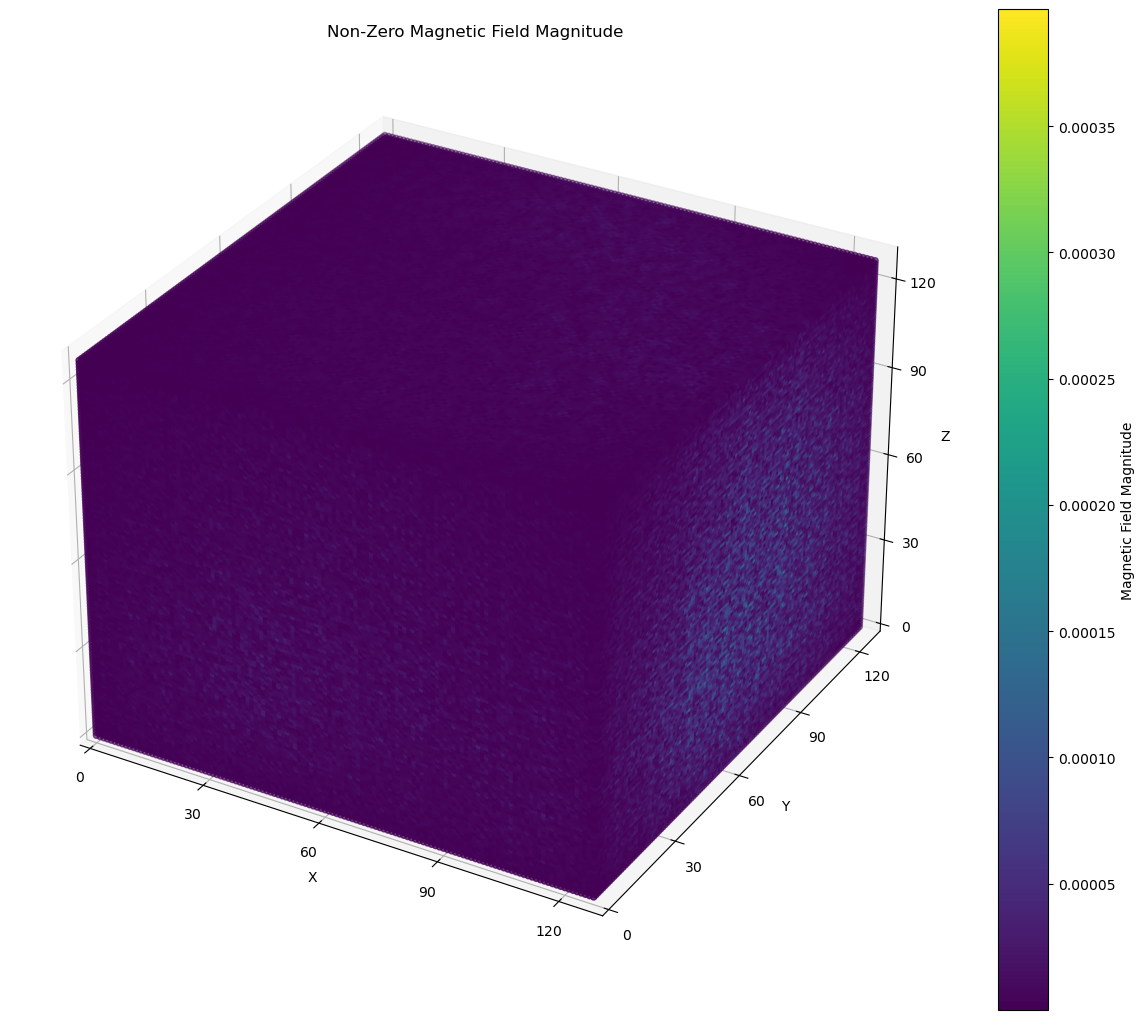

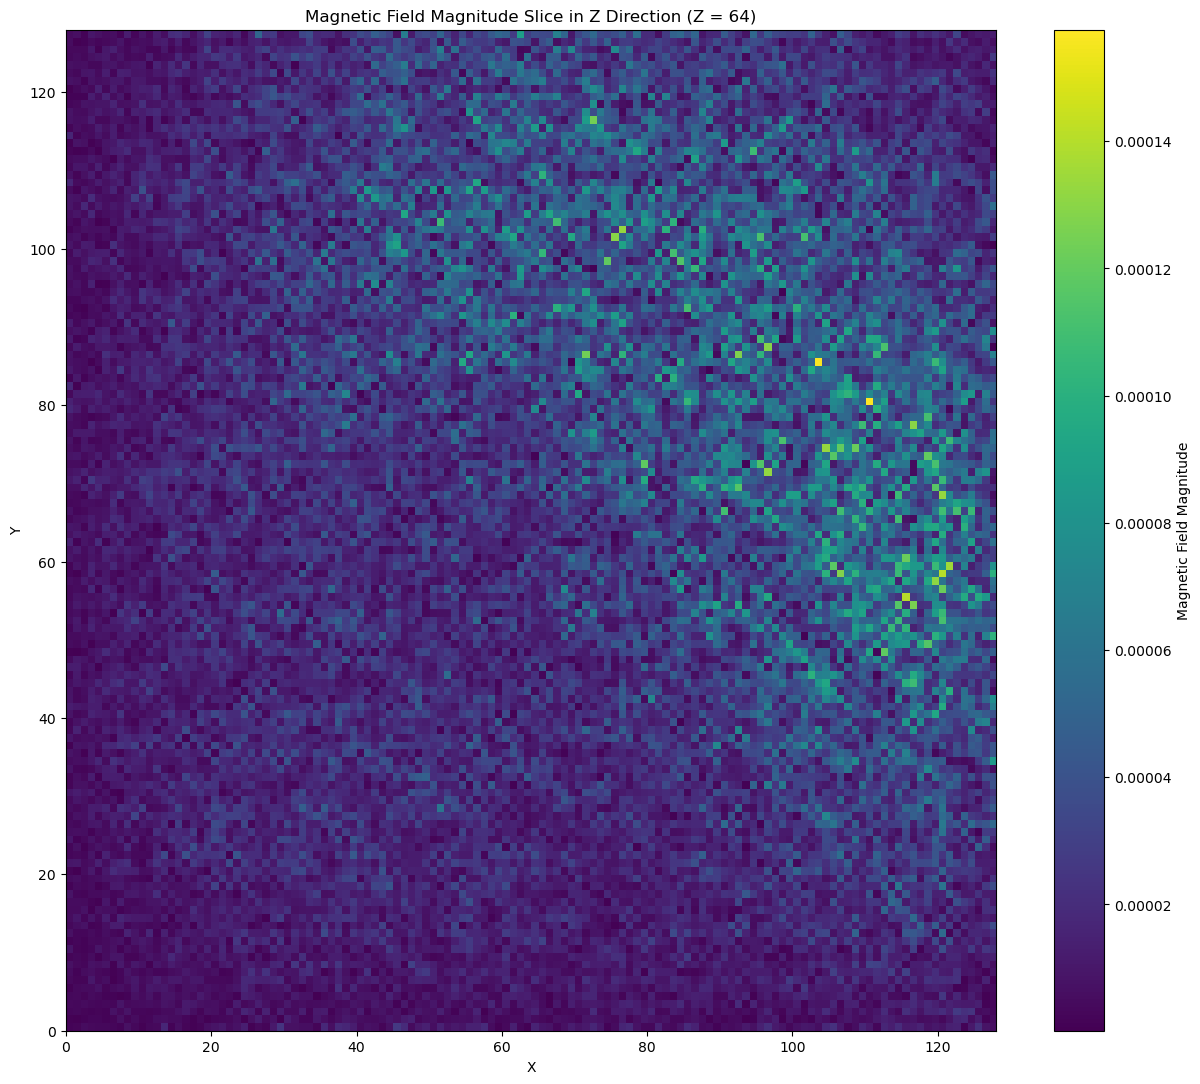

Predicted magnetic field components for the 11th timestep:
Bx: [[[ 3.58209093e-07 -3.45287333e-07  2.24977316e-06 ...  7.54511916e-07
    6.22935703e-09 -2.00181901e-07]
  [-1.02874218e-07 -3.53233673e-07  6.58247245e-07 ...  6.08220105e-08
    2.90498754e-08 -1.71751338e-07]
  [-2.45940811e-07  1.41776482e-07 -5.09541906e-07 ... -4.68982279e-07
   -2.49112446e-07  1.31139313e-08]
  ...
  [ 6.99154725e-07 -5.43623059e-07  2.46258622e-07 ... -1.28113129e-07
   -9.03491326e-08 -5.63627623e-07]
  [ 1.67593817e-06 -1.71139936e-06 -3.45166001e-07 ... -4.32052047e-08
   -2.04536590e-07  1.04877479e-07]
  [ 2.45659152e-07 -2.23843108e-06 -9.63621076e-08 ...  1.59946342e-06
    9.63270281e-07  1.57986415e-06]]

 [[ 4.47721135e-07  1.28361876e-06 -1.63320340e-06 ...  4.56401864e-07
    1.86300554e-07  3.67721952e-07]
  [-1.42617456e-08  1.07307557e-07  1.59297727e-07 ...  2.85024293e-09
    1.08235774e-07  1.72142677e-07]
  [-1.36074831e-07  1.08469258e-07 -3.26542882e-08 ...  1.10495830e-06
  

In [28]:
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import MaxNLocator, ScalarFormatter

# Constants
PATH_TO_VOLUME_DATA = '/pscratch/sd/j/jcurcio/pcnn/Volume_Data/'
n_pixels = 128
n_predict = 10  # timestep, 0th indexed

# Load data
Jx = np.load(PATH_TO_VOLUME_DATA + f'Jx_3D_vol_{n_pixels}_{n_predict}.npy').reshape([1, n_pixels, n_pixels, n_pixels, 1])
Jy = np.load(PATH_TO_VOLUME_DATA + f'Jy_3D_vol_{n_pixels}_{n_predict}.npy').reshape([1, n_pixels, n_pixels, n_pixels, 1])
Jz = np.load(PATH_TO_VOLUME_DATA + f'Jz_3D_vol_{n_pixels}_{n_predict}.npy').reshape([1, n_pixels, n_pixels, n_pixels, 1])

# Latent space inputs, un-used, all zeros
z_input = np.zeros([1, 8, 8, 8, 1]).astype(np.float32)

# Load model
model_A = load_model('../Trained_Models/PCNN_10.h5')

# Predict Ax
inputs = [Jx, z_input]
Ax_predicted, _ = model_A.predict(inputs)

# Predict Ay
inputs = [Jy, z_input]
Ay_predicted, _ = model_A.predict(inputs)

# Predict Az
inputs = [Jz, z_input]
Az_predicted, _ = model_A.predict(inputs)

# Reshape the predictions to remove the single channel dimension
Ax_predicted = Ax_predicted[0, ..., 0]  # Shape: (128, 128, 128)
Ay_predicted = Ay_predicted[0, ..., 0]  # Shape: (128, 128, 128)
Az_predicted = Az_predicted[0, ..., 0]  # Shape: (128, 128, 128)

# Compute numerical derivatives to get the magnetic fields
def compute_derivatives(A, dx, dy, dz):
    A_y = np.gradient(A, axis=1) / dy
    A_z = np.gradient(A, axis=2) / dz
    A_x = np.gradient(A, axis=0) / dx
    return A_x, A_y, A_z

dx = dy = dz = 1  # Assuming unit spacing for simplicity; adjust if necessary

Ax1_x, Ax1_y, Ax1_z = compute_derivatives(Ax_predicted, dx, dy, dz)
Ay1_x, Ay1_y, Ay1_z = compute_derivatives(Ay_predicted, dx, dy, dz)
Az1_x, Az1_y, Az1_z = compute_derivatives(Az_predicted, dx, dy, dz)

# Magnetic Fields
Bx_predicted = Az1_y - Ay1_z  # Bx = ∂Az/∂y - ∂Ay/∂z
By_predicted = Ax1_z - Az1_x  # By = ∂Ax/∂z - ∂Az/∂x
Bz_predicted = Ay1_x - Ax1_y  # Bz = ∂Ay/∂x - ∂Ax/∂y

print('Number of zero elements in Bx: ', len(Bx_predicted.flatten()) - np.count_nonzero(Bx_predicted))
print('Number of zero elements in By: ', len(By_predicted.flatten()) - np.count_nonzero(By_predicted))
print('Number of zero elements in Bz: ', len(Bz_predicted.flatten()) - np.count_nonzero(Bz_predicted))

# PLOTTING
# ------------------------------------------------------------------------------------------------------------


# Compute the magnitude of the magnetic field vectors
B_magnitude = np.sqrt(Bx_predicted**2 + By_predicted**2 + Bz_predicted**2)

# Create a mask for non-zero magnitudes
mask = B_magnitude > 0

# 3D Scatter plot for non-zero values of the magnetic field magnitudes
def plot_magnetic_field(Bx, By, Bz, B_magnitude, mask, title):
    fig = plt.figure(figsize=(15, 13))
    ax = fig.add_subplot(111, projection='3d')

    # Create meshgrid for plotting
    x, y, z = np.meshgrid(np.arange(n_pixels), np.arange(n_pixels), np.arange(n_pixels), indexing='ij')

    # Flatten arrays for plotting
    x_flattened = x.flatten()
    y_flattened = y.flatten()
    z_flattened = z.flatten()
    B_magnitude_flattened = B_magnitude.flatten()

    # Get non-zero indices for the magnetic field magnitudes
    non_zero_indices = np.nonzero(mask.flatten())

    # Scatter plot of non-zero magnetic field magnitudes
    if len(non_zero_indices[0]) > 0:
        sc = ax.scatter(x_flattened[non_zero_indices], y_flattened[non_zero_indices],
                        z_flattened[non_zero_indices], c=B_magnitude_flattened[non_zero_indices],
                        cmap='viridis', s=20, vmin=B_magnitude.min(), vmax=B_magnitude.max())
        fig.colorbar(sc, label='Magnetic Field Magnitude')
    else:
        # Add a placeholder plot for all-zero data
        ax.text2D(0.5, 0.5, "No Data", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

    # Set axis limits
    ax.set_xlim(0, n_pixels)
    ax.set_ylim(0, n_pixels)
    ax.set_zlim(0, n_pixels)

    # Customize plot appearance
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)

    # Adjust viewing angle
    ax.view_init(elev=30, azim=-60)

    # Format the tick labels to reduce precision
    ax.xaxis.set_major_locator(MaxNLocator(nbins=5))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
    ax.zaxis.set_major_locator(MaxNLocator(nbins=5))

    ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False, useMathText=True))
    ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False, useMathText=True))
    ax.zaxis.set_major_formatter(ScalarFormatter(useOffset=False, useMathText=True))

    plt.show()

# 2D Heatmap for a slice in the z direction
def plot_slice(B_magnitude, slice_index, title):
    fig, ax = plt.subplots(figsize=(15, 13))

    # Plot the heatmap for the specified z slice
    c = ax.imshow(B_magnitude[:, :, slice_index], cmap='viridis', origin='lower',
                  extent=(0, n_pixels, 0, n_pixels), aspect='auto')
    fig.colorbar(c, label='Magnetic Field Magnitude')

    # Customize plot appearance
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(f'{title} (Z = {slice_index})')

    plt.show()

# Plot the magnetic field magnitudes in a scatter plot
plot_magnetic_field(Bx_predicted, By_predicted, Bz_predicted, B_magnitude, mask, 'Non-Zero Magnetic Field Magnitude')

# Plot a slice in the z direction (middle slice)
middle_slice_index = n_pixels // 2
plot_slice(B_magnitude, middle_slice_index, 'Magnetic Field Magnitude Slice in Z Direction')

print("Predicted magnetic field components for the 11th timestep:")
print("Bx:", Bx_predicted)
print("By:", By_predicted)
print("Bz:", Bz_predicted)
